# GW cosmography with standard sirens
## A mock analysis

In this notebook, we will perform the Bayesian analysis following the paper [The Hitchhiker's guide to the galaxy catalog approach for gravitational wave cosmology](https://arxiv.org/abs/2212.08694). Their approach is implemented here in the [`DrawnGWInference` classes](./likelihood.py).

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
from catalog.utils import GalaxyCatalog
from inference.likelihood import (
    DrawnGWCatalogPerfectRedshiftInference,
    DrawnGWCatalogFullInference,
    DrawnGWMergerRatePriorInference
)

### Generating the CBC events

We use the GLADE+ catalog for the redshift information. For the GW data, we make the assumption that the GW signals come from the galaxies within the catalog, and draw (at random) a value of $z$ corresponding to a particular galaxy in the catalog, up to $z_\text{max} < 1.4$, following the methodology in the paper.

In [19]:
filename = "./catalog/output.hdf5"
catalog = GalaxyCatalog(filename)

We draw a set of sky directions $\{(\theta_i, \varphi_i)\}$ and we consider circular patches with a fixed angular radius $\alpha$ for each of them, which we consider as the GW localisation area. We select all galaxies within each patch up to $z_\text{max}=1.4$, and we draw $N_{\text{GW}}$ events for each of them.

In [20]:
# Parameters
z_max = 1.4
n_dir = 5
n_min = 100
n_gw_per_dir = 40
alpha = np.radians(2)

In [21]:
# Draw galaxy redshifts and masses in n_dir directions, with at least n_min per direction
drawn_galaxies = catalog.draw_galaxies(n_dir, alpha, n_min)
z_gal = [catalog.z[galaxies_at_direction] for galaxies_at_direction in drawn_galaxies]
mass_gal = [catalog.mass[galaxies_at_direction] for galaxies_at_direction in drawn_galaxies]

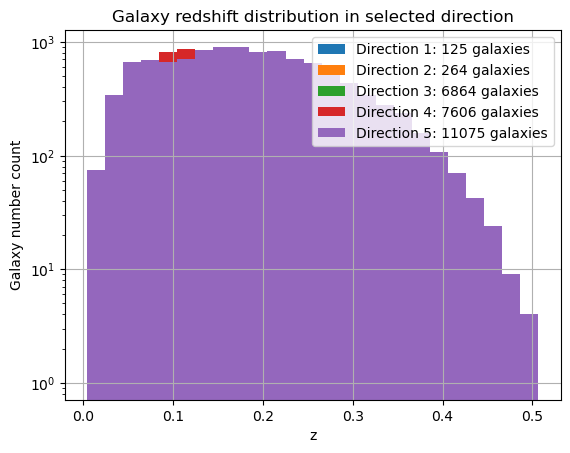

In [22]:
for i, z_gal_in_dir in enumerate(z_gal):
    plt.hist(z_gal_in_dir, bins=25, log=True, label=f"Direction {i + 1}: {len(z_gal_in_dir)} galaxies")
plt.xlabel('z')
plt.ylabel('Galaxy number count')
plt.title('Galaxy redshift distribution in selected direction')
plt.legend()
plt.grid()
plt.show()

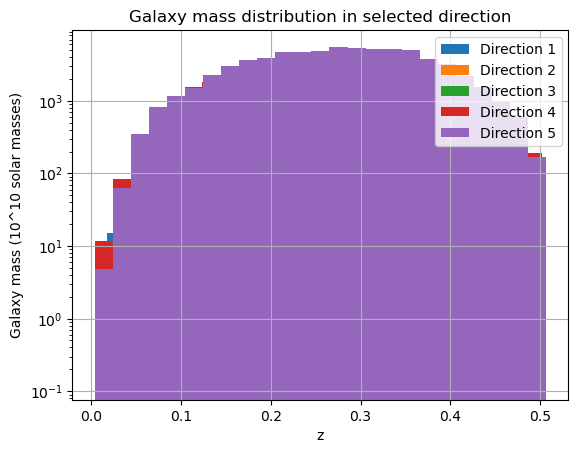

In [23]:
for i, (z_gal_in_dir, mass_gal_in_dir) in enumerate(zip(z_gal, mass_gal)):
    plt.hist(z_gal_in_dir, bins=25, log=True, weights=mass_gal_in_dir, label=f"Direction {i + 1}")
plt.xlabel('z')
plt.ylabel('Galaxy mass (10^10 solar masses)')
plt.title('Galaxy mass distribution in selected direction')
plt.legend()
plt.grid()
plt.show()

The mergers' redshifts are drawn from the galaxy catalog and are then converted to luminosity distance supposing a fiducial flat $\Lambda \text{CDM}$ cosmology, with $H_0 = 70 \, \rm{km} \, \rm{s}^{-1}\, \rm{Mpc}^{-1}$ and $\Omega_{m0} = 0.3$. For simplicity, we follow the reference paper by discarding events whose $d_L > d_L^{\text{threshold}} = 1550 \, \rm{Mpc}$. The *measured* luminosity distances of the events are drawn from a normal distribution $\hat{d}^i_L \sim \mathcal{N}(d^i_L, C d_L)$ for different values of $C$:

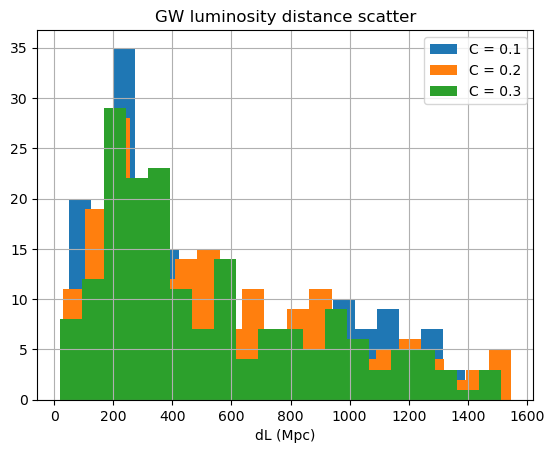

In [24]:
fiducial_H0 = 70.
c_values = [0.1, 0.2, 0.3]
colors = ['tab:blue', 'tab:orange', 'tab:green']
nc = len(c_values)
perfect_redshift_inference = DrawnGWCatalogPerfectRedshiftInference(fiducial_H0=fiducial_H0)
gw_dl_events = np.empty((len(c_values), n_dir), dtype=object)
for i, c in enumerate(c_values):
    gw_dl_events[i, :] = [
        perfect_redshift_inference.draw_gw_events(z_gal_i, c, n_gw=n_gw_per_dir)
        for z_gal_i in z_gal
    ]
    plt.hist(np.concatenate(gw_dl_events[i, :]), bins=20, label=f"C = {c}")
plt.xlabel('dL (Mpc)')
plt.title('GW luminosity distance scatter')
plt.legend()
plt.grid()
plt.show()

Below, we draw events with probabilities weighted by the candidate galaxies' masses:

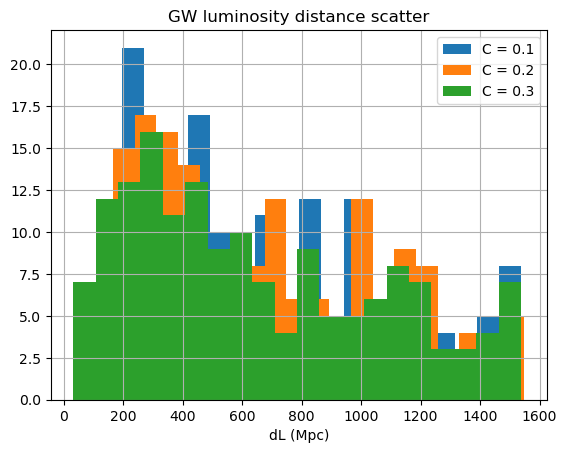

In [25]:
gw_dl_events_weighted = np.empty((len(c_values), n_dir), dtype=object)
for i, c in enumerate(c_values):
    gw_dl_events_weighted[i, :] = [
        perfect_redshift_inference.draw_gw_events(z_gal_i, c, n_gw=n_gw_per_dir, mass_gal=mass_gal_i)
        for z_gal_i, mass_gal_i in zip(z_gal, mass_gal)
    ]
    plt.hist(np.concatenate(gw_dl_events_weighted[i, :]), bins=20, label=f"C = {c}")
plt.xlabel('dL (Mpc)')
plt.title('GW luminosity distance scatter')
plt.legend()
plt.grid()
plt.show()

### Case I: negligible galaxy redshift uncertainty

In this section, we compute the posterior probability $p(H_0 | d_{\text{GW}}) \propto p(d_{\text{GW}} | H_0)p(H_0)$ under the assumption that the true galaxy redshifts are known (i.e that we made a perfect measurement). The single event likelihood becomes

\begin{equation}
p(d_i | H_0) = 
\frac{\sum_i^{N_\text{gal}} p(d_i | d_L(\hat{z}^i_\text{gal}, H_0))}{\sum_i^{N_\text{gal}} P^{\text{GW}}_{\text{det}}(\hat{z}^i_\text{gal}, H_0)}
\end{equation}

which corresponds to Eq. (15) of the paper.

In [26]:
n_H0 = 200
H0_array = np.linspace(20., 140., n_H0)

We now analyse the posterior distribution of $H_0$ for different values of $C = \sigma_{d_L} / d_L$:

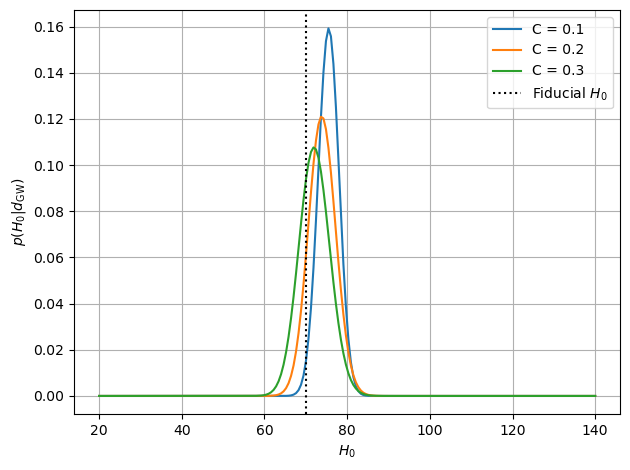

In [27]:
specz_posteriors = []
for c, gw_dl_array, color in zip(c_values, gw_dl_events, colors):
    inference = DrawnGWCatalogPerfectRedshiftInference(sigma_constant=c, fiducial_H0=fiducial_H0)
    posterior, _ = inference.likelihood(gw_dl_array, H0_array, z_gal, n_dir=n_dir)
    plt.plot(H0_array, posterior, label=f"C = {c}", color=color)
    specz_posteriors.append(posterior)

plt.axvline(fiducial_H0, c='k', label=r"Fiducial $H_0$", linestyle='dotted')
plt.grid()
plt.xlabel(r"$H_0$")
plt.ylabel(r"$p(H_0 | d_\text{GW})$")
plt.legend()
plt.tight_layout()
#plt.savefig('figures/perfect-redshift-posterior.png', dpi=400)
plt.show()

We perform the same calculation for the samples which were drawn weighted by the galaxies' masses:

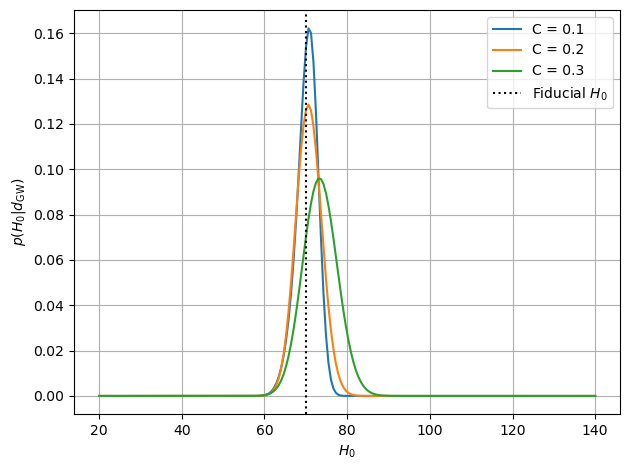

In [28]:
specz_mass_weighted_posteriors = []
for c, gw_dl_array, color in zip(c_values, gw_dl_events_weighted, colors):
    inference = DrawnGWCatalogPerfectRedshiftInference(sigma_constant=c, fiducial_H0=fiducial_H0)
    posterior, _ = inference.likelihood(gw_dl_array, H0_array, z_gal, n_dir=n_dir, mass_gal=mass_gal)
    plt.plot(H0_array, posterior, label=f"C = {c}", color=color)
    specz_mass_weighted_posteriors.append(posterior)

plt.axvline(fiducial_H0, c='k', label=r"Fiducial $H_0$", linestyle='dotted')
plt.grid()
plt.xlabel(r"$H_0$")
plt.ylabel(r"$p(H_0 | d_\text{GW})$")
plt.legend()
plt.tight_layout()
plt.show()

### Case II: Incorporating galaxy redshift uncertainty into the analysis

In the second case, we take into account the fact that the galaxy redshift measurement is not perfect. Because of this, the integration over the galaxies' true redshifts is no longer trivial - delta functions are replace by a gaussian PDF - and the full expression for the posterior becomes Eq. (29) in the paper.

The posterior is marginalized over the events' true redshifts, and the galaxies contribute only in the rate term ($p_\text{cbc}(z)$ in the paper).

Care must be taken when choosing the number $n_z$ of redshift points for integration. The galaxy redshift uncertainty is $\sigma_z \approx 0.013(1+z)^3$. If $\Delta z = (z_\text{max} - z_\text{min}) / n_z$ is of the order of $\sigma_z$ or larger, the numerical integrals on $z$ will not be well resolved.

In [29]:
full_catalog_inference = DrawnGWCatalogFullInference(fiducial_H0=fiducial_H0)
min_sigma_z = np.min(full_catalog_inference.redshift_sigma(np.concatenate(z_gal)))
print('Minimum of sigma_z: {:.4f}'.format(min_sigma_z))

z_min = min([np.min(z_gal_i) for z_gal_i in z_gal])
print(f'Value n_z for resolution ~ sigma_z: {round((z_max - z_min) / min_sigma_z)}')

Minimum of sigma_z: 0.0132
Value n_z for resolution ~ sigma_z: 106


We should thus pick $n_z$ (at least) an order of magnitude greater than this value.

In [30]:
n_z = 2000
z = np.linspace(z_min, z_max, n_z)

Let us visualize how the estimated selection effects evolve with $H_0$:

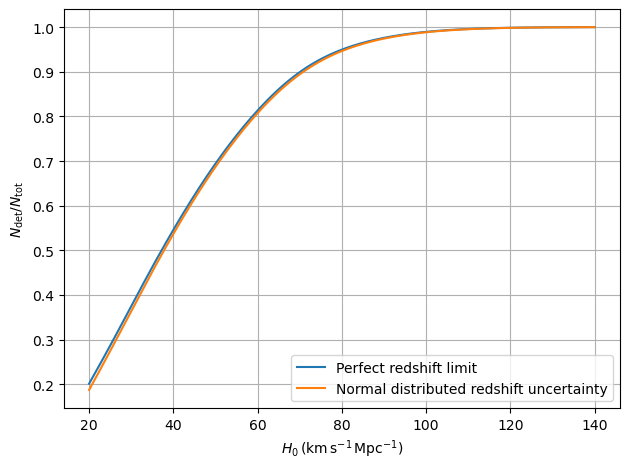

In [31]:
p_rate = full_catalog_inference.p_cbc(z, np.concatenate(z_gal))
selection_effects_perfect_redshift = perfect_redshift_inference.selection_effects(H0_array, np.concatenate(z_gal))
selection_effects = full_catalog_inference.selection_effects(H0_array, z, p_rate)
plt.plot(H0_array, selection_effects_perfect_redshift, label="Perfect redshift limit")
plt.plot(H0_array, selection_effects, label="Normal distributed redshift uncertainty")
plt.xlabel(r"$H_0 \, (\rm{km} \, \rm{s}^{-1} \, \rm{Mpc}^{-1})$")
plt.ylabel(r"$N_\text{det}/N_\text{tot}$")
plt.grid()
plt.legend()
plt.tight_layout()
#plt.savefig('figures/selection-effects.png', dpi=400)
plt.show()

The $y$-axis represents the ratio of detections over the total number of events. We observe that it grows approximately linearly up to 0.8 for
$H_0 \sim 60 \, \rm{km} \, \rm{s}^{-1} \, \rm{Mpc}^{-1}$, and asymptotes 1 for $H_0 \gtrsim 100 \, \rm{km} \, \rm{s}^{-1} \, \rm{Mpc}^{-1}$. Therefore, for fixed cosmological parameters ($\Omega_i$, etc), higher values of $H_0$ favor detection, as $d_L \propto H_0^{-3}$ becomes smaller and thus more events become comparatively smaller than the threshold $d_L^\text{th}$.

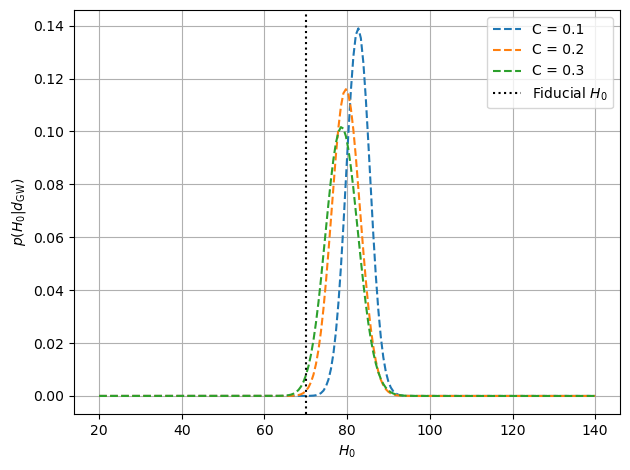

In [32]:
photoz_posteriors = []

for c, gw_dl_array, color in zip(c_values, gw_dl_events, colors):
    inference = DrawnGWCatalogFullInference(sigma_constant=c, fiducial_H0=fiducial_H0)
    posterior, _ = inference.likelihood(gw_dl_array, H0_array, z, z_gal, n_dir=n_dir)
    plt.plot(H0_array, posterior, label=f"C = {c}", color=color, linestyle='dashed')
    photoz_posteriors.append(posterior)

plt.axvline(fiducial_H0, c='k', label=r"Fiducial $H_0$", linestyle='dotted')
plt.grid()
plt.xlabel(r"$H_0$")
plt.ylabel(r"$p(H_0 | d_\text{GW})$")
plt.legend()
plt.tight_layout()
#plt.savefig('figures/full-inference-posterior.png', dpi=400)
plt.show()

Now we compare both methods:

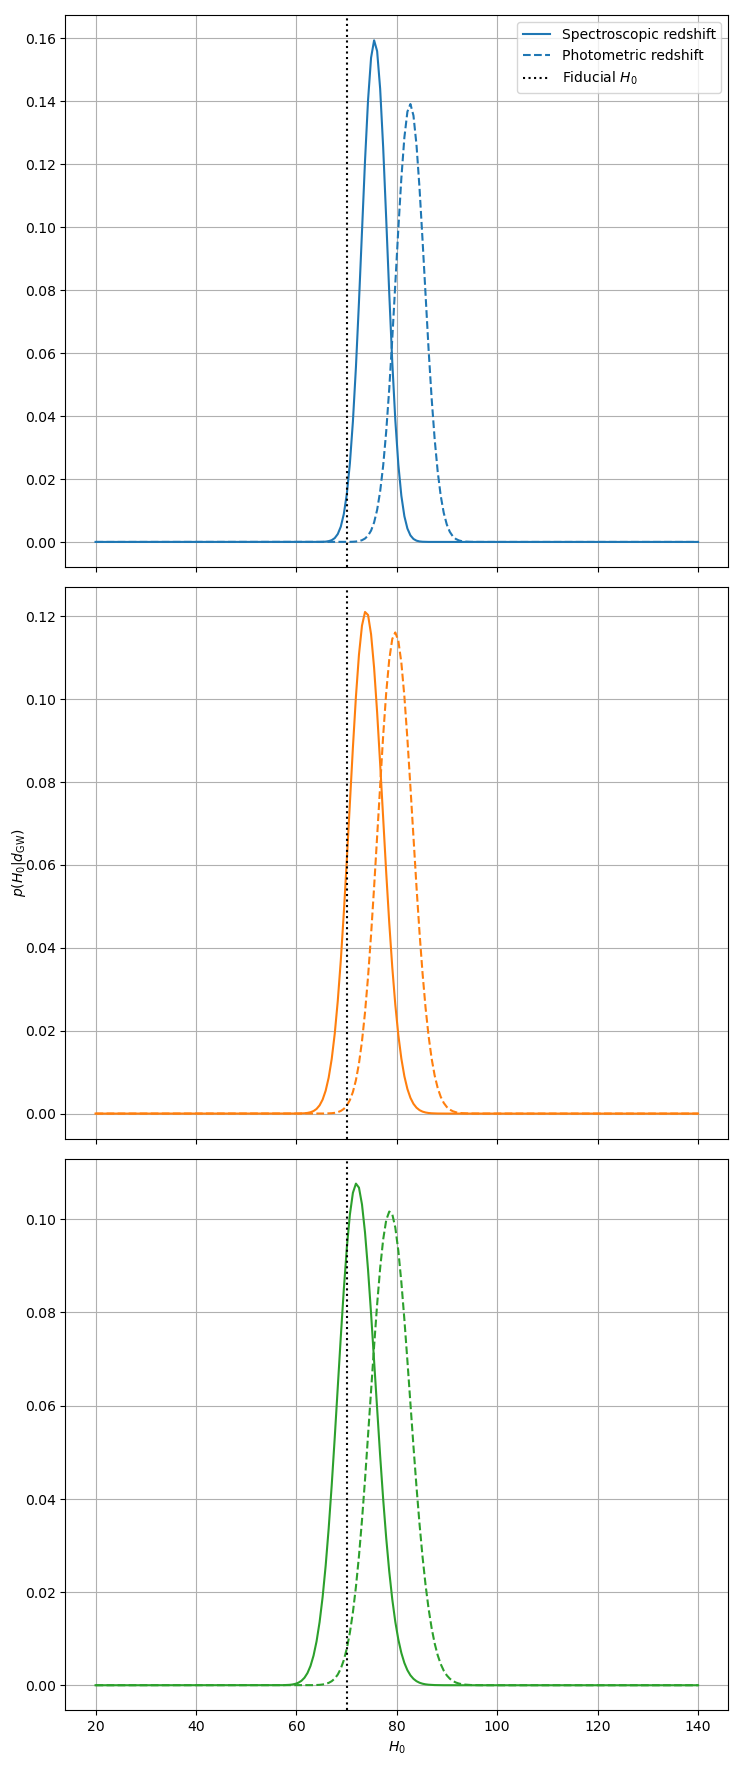

In [33]:
fig, axs = plt.subplots(nc, 1, sharex=True, figsize=(8, 18))
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
for ax, specz_posterior, photoz_posterior, color in zip(axs, specz_posteriors, photoz_posteriors, colors):
    ax.plot(H0_array, specz_posterior, label="Spectroscopic redshift", color=color, linestyle='solid')
    ax.plot(H0_array, photoz_posterior, label="Photometric redshift", color=color, linestyle='dashed')
    ax.axvline(fiducial_H0, c='k', label=r"Fiducial $H_0$", linestyle='dotted')
    ax.grid()

axs[0].legend()
plt.xlabel(r"$H_0$")
plt.ylabel(r"$p(H_0 | d_\text{GW})$")
fig.tight_layout()
#fig.savefig('figures/posterior-comparison.png', dpi=400)
plt.show()

The posterior distribution of $H_0$ seems to be more biased with respect to its true value when compared to Case I. One reason for this is an inconsistency with the event-generating process: in Case I, the GW redshifts were drawn from the *true* galaxy redshifts. Here, the GW redshifts were drawn from the *observed* galaxy redshifts, as we do not have access to their true values anymore.

### Case III: Using a fixed merger rate model as redshift prior

Alternatively, we can model the redshift probability distribution, $p_\text{cbc}(z)$, with prior knowledge on the star formation rate. In this scenario, we model this probability as 

$$
p_\text{cbc}(z) \propto \mathcal{R}(z) \frac{dV_c}{dz} \frac{1}{1 + z}
$$

where $\mathcal{R}(z)$ is the merger rate per comoving volume, $dN/DV_c dt_s$, where $t_s$ is the source frame time. We take $\mathcal{R}(z)$ to be proportional to the Madau-Dickinson star formation rate.

Let us compare $p_\text{cbc}(z)$ from the galaxy catalog method and from here. We expect them to be quite different, with the galaxy catalog calculation underestimating the redshift peak due to catalog incompleteness. Indeed, the Madau-Dickinson curve peaks at $z \sim 2$, whereas the GLADE+ catalog is severy incomplete there:

TypeError: DrawnGWMergerRatePriorInference.p_cbc() missing 1 required positional argument: 'theta'

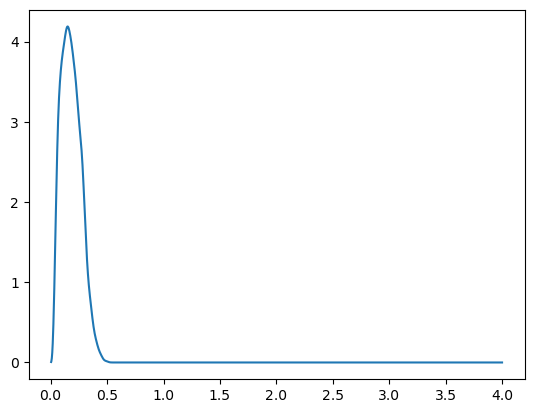

In [34]:
z = np.linspace(z_min, 4, n_z)
merger_rate_inference = DrawnGWMergerRatePriorInference(fiducial_H0=fiducial_H0)
plt.plot(z, full_catalog_inference.p_cbc(z, np.concatenate(z_gal)), label="Galaxy catalog method")
plt.plot(z, merger_rate_inference.p_cbc(z), label="Fixed merger rate prior")
plt.title(r"$p_\text{cbc}$ estimate for different inference methods")
plt.xlabel(r'$z$')
plt.ylabel(r"$p_\text{cbc}(z)$")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('figures/redshift-prior.png', dpi=400)
plt.show()

It is also important to note that performing Bayesian inference with a fixed merger rate model from Case III with events generated from an incomplete catalog (as in Cases I and II) will inevitably lead to a biased posterior, as the data generating process is not consistent with the redshift prior. We can visualize that when naively attempting to compute the posterior with the same data as before:

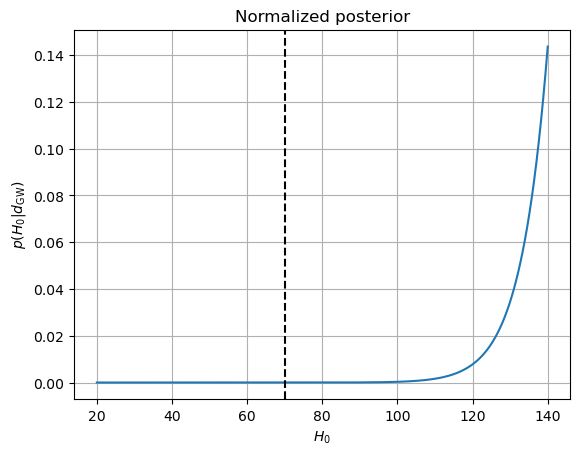

In [ ]:
full_likelihood, _ = DrawnGWMergerRatePriorInference(fiducial_H0=fiducial_H0).likelihood(gw_dl_array, H0_array, z)
plt.plot(H0_array, full_likelihood)
plt.axvline(fiducial_H0, ls='--', c='k')
plt.grid()
plt.title("Normalized posterior")
plt.xlabel(r"$H_0$")
plt.ylabel(r"$p(H_0 | d_\text{GW})$")
plt.show()

The posterior considerably overestimates $H_0$. This is due to the fact that the distribution of generated CBCs is artificially concentrated at low $z$ with respect to the (assumed) true distribution, $p_\text{cbc}(z)$.